# <center> Steam Review Sentiment Analysis </center>
---

### steam에서의 리뷰를 활용한 감성분석

## 0. 라이브러리

- 참조 코드(https://wikidocs.net/44249)
- 이해가 부족해서 좀 더 공부하고 정리해봐야 할 것 같습니다.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 1. 데이터 불러오기 및 전처리

In [2]:
steam_review = pd.read_table('steam.txt', header = None, names=['score', 'review'])

In [3]:
len(steam_review)

100000

In [4]:
steam_review.head() 
# 0 = 부정 리뷰
# 1 = 긍정 리뷰  

,score,review
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [5]:
steam_review.isnull().sum() # null값 확인 -> 결측치 없음

score     0
review    0
dtype: int64

In [6]:
steam_review['score'].nunique() # 1(긍정) / 0(부정)

2

In [7]:
steam_review['review'].nunique() # 중복 리뷰 

99892

In [8]:
steam_review.drop_duplicates(subset=['review'], inplace=True) # 중복 리뷰 제거

In [9]:
len(steam_review)

99892

In [10]:
steam_review

,score,review
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요
...,...,...
99995,0,한글화해주면 10개산다
99996,0,개쌉노잼 ㅋㅋ
99997,0,노잼이네요... 30분하고 지웠어요...
99998,1,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.


### train/test 분리

In [11]:
# 8:2
# train_review 
train_review = steam_review[:79914]

# test_review
test_review = steam_review[79915:]

In [12]:
print(len(train_review))
print(len(test_review))

79914
19977


## 2. 평점(score) 분포 확인

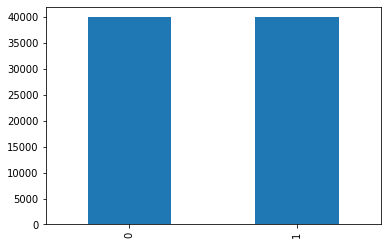

In [13]:
train_review['score'].value_counts().plot(kind = 'bar')
# 거의 5:5 비율로 나뉘어져 있음 확인

In [14]:
train_review.groupby('score').size().reset_index(name = 'count')

,score,count
0,0,39972
1,1,39942


In [15]:
train_review

,score,review
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요
...,...,...
79979,1,뭐야 시방.... 개발자들 다 어디감ㅋㅋㅋㅋㅋㅋ 게임 자체는 진짜 말 그대로 거의 ...
79980,1,시발 라디오 틀지마
79981,0,"매력있고,개성있는데 그게 다임;;"
79982,1,뭔가 열심히 하려는건 좋은데.. 그게 그거네... 참... 애초에 뭘 기대한건지.....


In [16]:
train_review['review'] = train_review['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# . , ! 와 같은 불필요한 것들 제거
# 한글과 공백 유지

C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
train_review.head()

,score,review
0,0,노래가 너무 적음
1,0,돌겠네 진짜 황숙아 어크 공장 그만 돌려라 죽는다
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악차악차악 정말 이래서 왕국을 되찾을 수 있는거야
4,1,시간 때우기에 좋음 도전과제는 시간이면 다 깰 수 있어요


## 3. Tokenize

- 참고 자료: https://soyoung-new-challenge.tistory.com/31

In [18]:
stopwords = ['의','가','이','은',
             '들','는','좀','잘','걍','과',
             '도','를','으로','자','에','와','한','하다']
# 불용어 -> stopwords에 정의

### train_review tokenize

In [19]:
okt = Okt() # 객체 생성
X_train = []
for sentence in train_review['review']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # okt = KoNLPy에서 제공하는 형태소 분석기
                                             # tokenize
        
    temp_X = [word for word in temp_X if not word in stopwords] 
    # stopwords에 정의되어 있는불용어 제거
    X_train.append(temp_X)

### test_review tokenize

In [20]:
X_test = []
for sentence in test_review['review']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

## 4. 정수 인코딩
- 기계가 텍스트를 **숫자**로 처리할 수 있도록 데이터에 정수 인코딩

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) 

In [22]:
print(tokenizer.word_index) # tokenizer.word_index로 고유한 정수 확인

{'게임': 1, '을': 2, '있다': 3, '없다': 4, '되다': 5, '이다': 6, '좋다': 7, '같다': 8, '보다': 9, '로': 10, '재밌다': 11, '안': 12, '겜': 13, '만': 14, '너무': 15, '다': 16, '않다': 17, '아니다': 18, '플레이': 19, '시간': 20, '못': 21, '적': 22, '것': 23, '에서': 24, '안되다': 25, '사다': 26, '때': 27, '추천': 28, '나': 29, '사람': 30, '재미': 31, '고': 32, '재미있다': 33, '거': 34, '해보다': 35, '개': 36, '인': 37, '만들다': 38, '나오다': 39, '그냥': 40, '스토리': 41, '생각': 42, '더': 43, '내': 44, '모르다': 45, '하고': 46, '수': 47, '게': 48, '왜': 49, '갓': 50, '많다': 51, '진짜': 52, '그': 53, '정말': 54, '아': 55, '버그': 56, '가다': 57, '어렵다': 58, '그래픽': 59, '돈': 60, '요': 61, '정도': 62, '그렇다': 63, '하': 64, '함': 65, '들다': 66, '자다': 67, '뭐': 68, '분': 69, '친구': 70, '면': 71, '싶다': 72, '알다': 73, '중': 74, '인데': 75, '해주다': 76, '환불': 77, '처음': 78, '주다': 79, '느낌': 80, '즐기다': 81, '일': 82, '하나': 83, '하지만': 84, '까지': 85, '좋아하다': 86, '멀티': 87, '말': 88, '말다': 89, '감': 90, '임': 91, '오다': 92, '버리다': 93, '난이도': 94, '받다': 95, '걸': 96, '저': 97, '구매': 98, '많이': 99, '지': 100, '실행': 101, '그리고': 102, '

In [23]:
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 3보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 3보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 3보다 작으면
    if(value < 3):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합 크기 :',total_cnt)
print('등장 빈도 2번 이하의 단어의 수: %s' % (rare_cnt))
print("단어 집합에서 등장 빈도 2번 이하의 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 등장 빈도 2번 이하의 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 등징 빈도가 2번 이하인 단어 집합이 57%로 절반 이상 차지
# 반면 전체 등장 빈도에서 등장 빈도가 2번 이하인 단어의 등장 빈도가 2% 밖에 차지하지 않음
# 자연어 처리에서 중요하지 않을 것이라 판단 -> 정수 인코딩 과정에서 배제

단어 집합 크기 : 31756
등장 빈도 2번 이하의 단어의 수: 18315
단어 집합에서 등장 빈도 2번 이하의 단어의 비율: 57.67414031993954
전체 등장 빈도에서 등장 빈도 2번 이하의 단어 등장 빈도 비율: 2.041197012133066


In [24]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 13443


In [25]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [26]:
print(X_train[:3])
print(X_test[:3])

[[701, 16, 334], [1147, 53, 11331, 56, 1603, 3822, 1262, 462, 174], [8135, 3110, 8135, 31, 76, 1314, 45, 27, 149, 69, 101]]
[[198, 7, 2], [1, 1, 25, 5346, 4143, 462, 480, 8969, 6565, 3, 3222, 708, 1151, 462, 8969, 1, 296, 23, 271, 11008, 559, 1, 103, 32, 5, 1, 53, 4893, 1358, 1, 171, 1994, 3748, 7044, 3, 12, 249, 638, 32, 5, 41], [1, 654, 297, 342, 5, 154]]


In [27]:
# y_train과 y_test를 별도로 저장
y_train = np.array(train_review['score'])
y_test = np.array(test_review['score'])

In [28]:
y_train

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [29]:
y_test

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

## 5. 빈 샘플 제거

In [30]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
# 

In [31]:
len(drop_train)

31

In [32]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

# 빈 샘플 제거 후 79,883개로 줄어듦.

79883
79883


## 6. 패딩

리뷰의 최대 길이 : 60
리뷰의 평균 길이 : 13.69030957775747


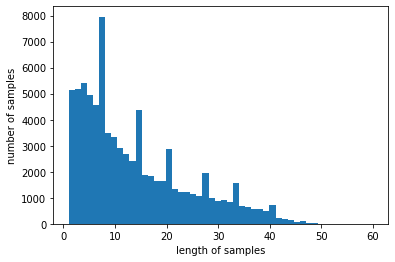

In [33]:
# 패딩 = 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 작업
# 리뷰 길이 분포 확인

print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [34]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [35]:
max_len = 40
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 98.6229861171964


In [36]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## 7. LSTM으로 Steam 리뷰 긍정/부정 분류
- 참고 자료<br>
https://tykimos.github.io/2017/03/25/Fit_Talk/
https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/

In [37]:
model = Sequential()
model.add(Embedding(vocab_size, 100)) # 임베딩 벡터의 차원 = 100
model.add(LSTM(128)) # LSTM -> 리뷰 분류
model.add(Dense(1, activation='sigmoid'))

In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# 검증 데이터 손실(val_loss)이 증가하면 과적합 징후
# 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)

mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max',
                     verbose=1, save_best_only=True)
# ModelCheckpoint 사용
# 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장

In [39]:
test_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19977 entries, 79985 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score   19977 non-null  int64 
 1   review  19977 non-null  object
dtypes: int64(1), object(1)
memory usage: 468.2+ KB


In [40]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

# 모의고사를 예로 생각해보자.
# batch_size(배치사이즈) =  몇 문항을 풀고 해답을 맞추는 지를 의미
# epoch(에포크) = 모의고사 1회분을 몇 번 풀어볼까 

Epoch 1/15
1065/1066 [============================>.] - ETA: 0s - loss: 0.5012 - acc: 0.7571
Epoch 00001: val_acc improved from -inf to 0.78569, saving model to best_model.h5
1066/1066 [==============================] - 96s 90ms/step - loss: 0.5012 - acc: 0.7571 - val_loss: 0.4610 - val_acc: 0.7857
Epoch 2/15
1066/1066 [==============================] - ETA: 0s - loss: 0.4399 - acc: 0.7984
Epoch 00002: val_acc improved from 0.78569 to 0.79076, saving model to best_model.h5
1066/1066 [==============================] - 88s 82ms/step - loss: 0.4399 - acc: 0.7984 - val_loss: 0.4538 - val_acc: 0.7908
Epoch 3/15
1065/1066 [============================>.] - ETA: 0s - loss: 0.4141 - acc: 0.8139
Epoch 00003: val_acc did not improve from 0.79076
1066/1066 [==============================] - 89s 83ms/step - loss: 0.4141 - acc: 0.8139 - val_loss: 0.4446 - val_acc: 0.7908
Epoch 4/15
1065/1066 [============================>.] - ETA: 0s - loss: 0.3932 - acc: 0.8259
Epoch 00004: val_acc improved from 0

In [41]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

625/625 [==============================] - 8s 13ms/step - loss: 0.4475 - acc: 0.7943

 테스트 정확도: 0.7943


In [42]:
len(X_test)

19977

## 8. 리뷰 예측하기

In [43]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [44]:
sentiment_predict('진짜 짜증나네 게임 왜 이럼')

93.59% 확률로 부정 리뷰입니다.



In [45]:
sentiment_predict('그저 갓겜...')

92.97% 확률로 긍정 리뷰입니다.



In [49]:
sentiment_predict('개노잼이다 진짜')

95.80% 확률로 부정 리뷰입니다.



In [60]:
sentiment_predict('ㅈㄴ 어이없네 ')

96.38% 확률로 부정 리뷰입니다.



In [51]:
sentiment_predict('거래 활성화 너무 잘 되있어')

81.11% 확률로 긍정 리뷰입니다.



In [59]:
sentiment_predict('개좋네 ㅋㅋㅋㅋ')

91.89% 확률로 긍정 리뷰입니다.

